In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


['/device:CPU:0', '/device:GPU:0']


# 0. Loading the data

### TinyImageNet does not have labels for the testing data. We will use the 10k validation images for the testing data.

In [2]:
from tensorflow.keras.utils import to_categorical  

#load cifar-10 dataset
(X_tot, y_tot), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
#one hot encoding
y_test=to_categorical(y_test, num_classes=100)
y_tot=to_categorical(y_tot, num_classes=100)

print(X_tot.shape)
print(y_tot.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 100)
(10000, 32, 32, 3)
(10000, 100)


In [3]:
#shuffle data and split data to generate validation data
shuffler = np.random.RandomState(seed=42).permutation(len(X_tot))
X_tot = X_tot[shuffler]
y_tot = y_tot[shuffler]
 

#validation data
X_val=X_tot[0:2000]
y_val=y_tot[0:2000]

X_train=X_tot[2000:]
y_train=y_tot[2000:]

# 1. Using ResNeXt29_8x64d with CIFAR100

### We use our custom resnet model generator to get any resnet 

CIFAR 100 has 100 different labels

We use a custom resnet model, because the images are 32x32 we do not need to go as deep to get good results.The CNN layers go to 2x2 resolution instead to 1x1 in a traditional resnet model.

In [7]:
from utils.custom_ResNeXt import custom_ResNeXt, custom_ResNeXt29

ResNeXt29=custom_ResNeXt29(input_shape=(32,32,3),n_classes=100,cardinality=8,model_name='custom_ResNext29_8x64d')
#tf.keras.utils.plot_model(ResNeXt29, to_file='test.png',show_shapes=True)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

path='./models/cifar100/ResNext29_best_cifar100.hdf5'
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=4, #+-8 pixel shift max
        height_shift_range=4)#+-8 pixel shift max


reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max',factor=0.1,
                              patience=5, min_lr=0.001, verbose=1)

#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=15)
# checkpoints
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
ResNeXt29.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),loss='categorical_crossentropy', metrics = ['acc'])


train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
step_size_train=train_generator.n//train_generator.batch_size

history=ResNeXt29.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=200,
                    validation_data=(X_val,y_val),
                    callbacks=[reduce_lr,es,checkpoint])

Epoch 1/200
375/375 [==============================] - 78s 178ms/step - loss: 4.3927 - acc: 0.0846 - val_loss: 3.3671 - val_acc: 0.1955

Epoch 00001: val_acc improved from -inf to 0.19550, saving model to ./models/cifar100/ResNext29_best_cifar100.hdf5
Epoch 2/200
375/375 [==============================] - 64s 172ms/step - loss: 3.1977 - acc: 0.2284 - val_loss: 3.1319 - val_acc: 0.2350

Epoch 00002: val_acc improved from 0.19550 to 0.23500, saving model to ./models/cifar100/ResNext29_best_cifar100.hdf5
Epoch 3/200
375/375 [==============================] - 64s 170ms/step - loss: 2.8192 - acc: 0.2953 - val_loss: 3.0049 - val_acc: 0.2790

Epoch 00003: val_acc improved from 0.23500 to 0.27900, saving model to ./models/cifar100/ResNext29_best_cifar100.hdf5
Epoch 4/200
375/375 [==============================] - 64s 171ms/step - loss: 2.5293 - acc: 0.3507 - val_loss: 2.7985 - val_acc: 0.3100

Epoch 00004: val_acc improved from 0.27900 to 0.31000, saving model to ./models/cifar100/ResNext29_be

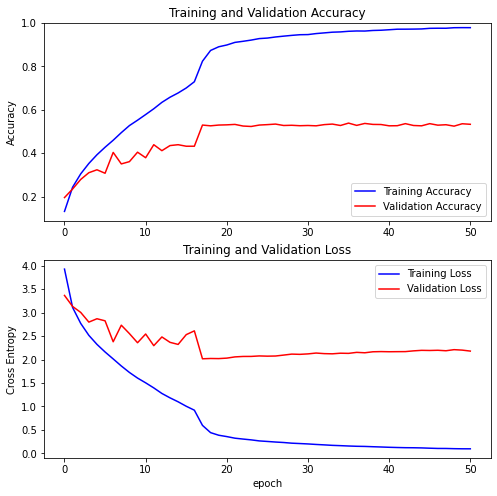

In [9]:
from utils.train_CIFAR_all import plot_model
plot_model(history)

In [10]:
print(history.history['acc'])
print(history.history['loss'])
print(history.history['val_acc'])
print(history.history['val_loss'])

[0.13175000250339508, 0.2433541715145111, 0.304791659116745, 0.35256248712539673, 0.39264583587646484, 0.4273333251476288, 0.4595625102519989, 0.4945833384990692, 0.5271250009536743, 0.5518541932106018, 0.57791668176651, 0.6045416593551636, 0.6340625286102295, 0.6576874852180481, 0.6773124933242798, 0.7002708315849304, 0.7290416955947876, 0.8235833048820496, 0.8731874823570251, 0.8900625109672546, 0.898354172706604, 0.9103333353996277, 0.9153333306312561, 0.9208958148956299, 0.9278333187103271, 0.9302499890327454, 0.9352291822433472, 0.9390624761581421, 0.9426249861717224, 0.9456250071525574, 0.9462916851043701, 0.9508958458900452, 0.9540625214576721, 0.9572708606719971, 0.9585833549499512, 0.9614791870117188, 0.9628958106040955, 0.9625416398048401, 0.9652083516120911, 0.9662708044052124, 0.968583345413208, 0.9710624814033508, 0.9711874723434448, 0.9715416431427002, 0.9722499847412109, 0.9750833511352539, 0.9755625128746033, 0.9754375219345093, 0.9779375195503235, 0.9782708287239075, 0

In [11]:
from utils.evaluate_model import score
# reload from saved weights:
model=custom_ResNeXt29(input_shape=(32,32,3),n_classes=100,cardinality=8,model_name='custom_ResNext29_8x64d')
model.load_weights(path)

if not os.path.exists('./full_models/cifar100'):
    os.makedirs('./full_models/cifar100')
model.save('./full_models/cifar100/ResNext29_best.h5')


score(model,X_test,y_test,top_n=[3,5])

313/313 - 13s - loss: 2.1037 - acc: 0.5463
custom_ResNext29_8x64d
model accuracy: 54.63%
top 3 accuracy: 74.02999997138977
top 5 accuracy: 80.9499979019165


# 2. Using SE_ResNeXt29_8x64d with CIFAR100

In [19]:
from utils.SE_ResNeXt import SE_ResNeXt29

SEResNeXt29=SE_ResNeXt29(input_shape=(32,32,3),n_classes=100,ratio=16,name='custom_ResNeXt29_SE')
#SEResNeXt.summary()

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

path='./models/cifar100/SE_ResNext29_best_cifar100.hdf5'
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=4, #+-8 pixel shift max
        height_shift_range=4)#+-8 pixel shift max


reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max',factor=0.1,
                              patience=5, min_lr=0.001, verbose=1)

#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=15)
# checkpoints
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
SEResNeXt29.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),loss='categorical_crossentropy', metrics = ['acc'])


train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
step_size_train=train_generator.n//train_generator.batch_size

history=SEResNeXt29.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=200,
                    validation_data=(X_val,y_val),
                    callbacks=[reduce_lr,es,checkpoint])

Epoch 1/200
375/375 [==============================] - 83s 189ms/step - loss: 4.0996 - acc: 0.0926 - val_loss: 3.3890 - val_acc: 0.1935

Epoch 00001: val_acc improved from -inf to 0.19350, saving model to ./models/cifar100/SE_ResNext29_best_cifar100.hdf5
Epoch 2/200
375/375 [==============================] - 68s 182ms/step - loss: 3.0267 - acc: 0.2507 - val_loss: 2.9452 - val_acc: 0.2775

Epoch 00002: val_acc improved from 0.19350 to 0.27750, saving model to ./models/cifar100/SE_ResNext29_best_cifar100.hdf5
Epoch 3/200
375/375 [==============================] - 68s 182ms/step - loss: 2.6321 - acc: 0.3300 - val_loss: 2.8116 - val_acc: 0.3040

Epoch 00003: val_acc improved from 0.27750 to 0.30400, saving model to ./models/cifar100/SE_ResNext29_best_cifar100.hdf5
Epoch 4/200
375/375 [==============================] - 68s 181ms/step - loss: 2.3564 - acc: 0.3841 - val_loss: 2.6671 - val_acc: 0.3320

Epoch 00004: val_acc improved from 0.30400 to 0.33200, saving model to ./models/cifar100/SE_

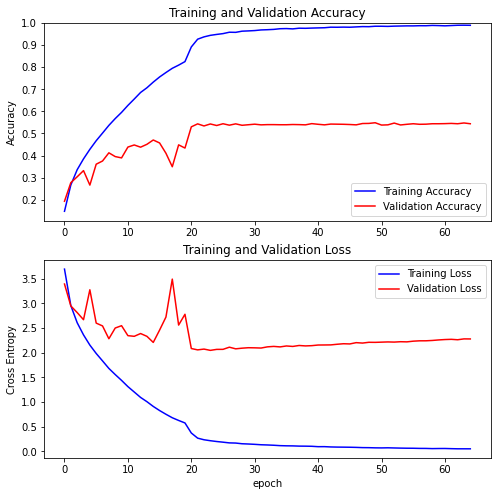

In [21]:
from utils.train_CIFAR_all import plot_model
plot_model(history)

In [22]:
print(history.history['acc'])
print(history.history['loss'])
print(history.history['val_acc'])
print(history.history['val_loss'])

[0.14804166555404663, 0.2671458423137665, 0.335999995470047, 0.3851458430290222, 0.4281249940395355, 0.4671874940395355, 0.5017083287239075, 0.5366041660308838, 0.5673333406448364, 0.5954166650772095, 0.6268958449363708, 0.6557291746139526, 0.6854583621025085, 0.7066875100135803, 0.7322708368301392, 0.7555833458900452, 0.7756458520889282, 0.7947291731834412, 0.8091250061988831, 0.8250208497047424, 0.8912916779518127, 0.9264166951179504, 0.9368749856948853, 0.9438124895095825, 0.9479583501815796, 0.9516458511352539, 0.957895815372467, 0.9573749899864197, 0.9626250267028809, 0.9638749957084656, 0.965416669845581, 0.9682499766349792, 0.9692916870117188, 0.9707499742507935, 0.9737708568572998, 0.9744583368301392, 0.9730208516120911, 0.9761041402816772, 0.9756249785423279, 0.9766666889190674, 0.9774791598320007, 0.9782291650772095, 0.9807083606719971, 0.9804166555404663, 0.981041669845581, 0.9805208444595337, 0.9819791913032532, 0.9833750128746033, 0.9829999804496765, 0.9849791526794434, 0.

In [23]:
# reload from saved weights:
model=SE_ResNeXt29(input_shape=(32,32,3),n_classes=100,ratio=16,name='custom_ResNeXt29_SE')
model.load_weights(path)

if not os.path.exists('./full_models/cifar100'):
    os.makedirs('./full_models/cifar100')
model.save('./full_models/cifar100/SE_ResNext29_best.h5')


score(model,X_test,y_test,top_n=[3,5])

313/313 - 15s - loss: 2.1584 - acc: 0.5528
SE_custom_ResNext29_8x64d
model accuracy: 55.28%
top 3 accuracy: 73.86000156402588
top 5 accuracy: 81.16000294685364
